In [95]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.3f}'.format

In [96]:
# network structure. First layer number should be = number of features
net_layers = (11,16,8,4)

epochs=100
patience=80

# trials
# (11,16,8,4)   -> 0.712
# 11 -> 11 -> 6 
# 11 -> 8 -> 6   -> 0.704
# 11 -> 11 -> 8 -> 4  -> 0.709

In [97]:
# 1- read data file
# 1- read processed file
file_dir = '../../data/processed-data/'
data_file = 'standardized_normalized_dataset.csv'
data = pd.read_csv(file_dir + data_file)

In [98]:
data.head(5)

svc_cpu_use  svc_cpu_thr  svc_net_use  svc_disk_use  system_cpu_use  \
0       -2.397       -1.146       -2.165        -2.248          -1.571   
1       -2.193       -1.270       -2.052        -2.129          -1.570   
2       -2.221       -1.206       -2.008        -2.227          -1.571   
3       -2.165       -1.270       -2.007        -1.404          -1.571   
4       -2.221       -1.206       -1.955        -1.105          -1.571   

   system_cpu_sat  system_net_use  svc_req_size  svc_resp_size  svc_pods  \
0          -1.348          -2.094        -1.754         -1.289    -1.485   
1          -1.347          -2.030        -1.672         -1.230    -1.485   
2          -1.365          -2.023        -1.607         -1.181    -1.485   
3          -1.337          -2.037        -1.624         -1.198    -1.709   
4          -1.321          -2.049        -1.616         -1.192    -2.379   

   svc_req_rate  ltcy  
0        -1.998 0.332  
1        -1.928 0.400  
2        -1.866 0.469  
3        -1.872 0.490  
4        -1.862 0.500

## Function to build a model

In [99]:
targets = data['ltcy']
inputs = data.drop(['ltcy'], axis=1)

x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=0.2, random_state=365)

# for better convergence and result scale target to values between 0 - 1
maxltcy = targets.max()
y_train = y_train / maxltcy
y_test = y_test / maxltcy


In [100]:
def build_model(nodes = net_layers):   # this does not work with KerasRegressor. interesting
    # create model
    model = Sequential()  
    model.add(Dense(nodes[1], input_dim=nodes[0], kernel_initializer='normal', activation='relu'))
    
    layer = 1
    while layer < len(nodes):
        model.add(Dense(nodes[layer], kernel_initializer='normal', activation='relu'))
        layer = layer + 1
        
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    # Compile model
    opt = Adam(lr=1e-3, decay=1e-3 / 200)
    # or loss= 'mean_absolute_percentage_error'
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse'])
    return model


In [101]:
model = build_model()

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

# save the best model only
mc = ModelCheckpoint('../models/best_mlp_model.h5', monitor='val_loss', mode='min' \
                     , verbose=1, save_best_only=True)

history = model.fit(x_train, y_train, epochs=epochs, verbose=1, validation_split=0.1, \
                    shuffle=False, callbacks=[es, mc])

print ("Done..!")


Train on 1140 samples, validate on 127 samples
Epoch 1/100
1140/1140 [==============================] - 2s 2ms/step - loss: 0.4090 - mean_squared_error: 0.4090 - val_loss: 0.3853 - val_mean_squared_error: 0.3853

Epoch 00001: val_loss improved from inf to 0.38534, saving model to ../models/best_mlp_model.h5
Epoch 2/100
1140/1140 [==============================] - 0s 70us/step - loss: 0.3542 - mean_squared_error: 0.3542 - val_loss: 0.3132 - val_mean_squared_error: 0.3132

Epoch 00002: val_loss improved from 0.38534 to 0.31320, saving model to ../models/best_mlp_model.h5
Epoch 3/100
1140/1140 [==============================] - 0s 71us/step - loss: 0.2221 - mean_squared_error: 0.2221 - val_loss: 0.1112 - val_mean_squared_error: 0.1112

Epoch 00003: val_loss improved from 0.31320 to 0.11121, saving model to ../models/best_mlp_model.h5
Epoch 4/100
1140/1140 [==============================] - 0s 73us/step - loss: 0.0681 - mean_squared_error: 0.0681 - val_loss: 0.0649 - val_mean_squared_error


Epoch 00031: val_loss improved from 0.01391 to 0.01389, saving model to ../models/best_mlp_model.h5
Epoch 32/100
1140/1140 [==============================] - 0s 66us/step - loss: 0.0145 - mean_squared_error: 0.0145 - val_loss: 0.0139 - val_mean_squared_error: 0.0139

Epoch 00032: val_loss improved from 0.01389 to 0.01387, saving model to ../models/best_mlp_model.h5
Epoch 33/100
1140/1140 [==============================] - 0s 67us/step - loss: 0.0144 - mean_squared_error: 0.0144 - val_loss: 0.0139 - val_mean_squared_error: 0.0139

Epoch 00033: val_loss improved from 0.01387 to 0.01387, saving model to ../models/best_mlp_model.h5
Epoch 34/100
1140/1140 [==============================] - 0s 65us/step - loss: 0.0144 - mean_squared_error: 0.0144 - val_loss: 0.0139 - val_mean_squared_error: 0.0139

Epoch 00034: val_loss did not improve from 0.01387
Epoch 35/100
1140/1140 [==============================] - 0s 76us/step - loss: 0.0144 - mean_squared_error: 0.0144 - val_loss: 0.0139 - val_mean

1140/1140 [==============================] - 0s 68us/step - loss: 0.0135 - mean_squared_error: 0.0135 - val_loss: 0.0137 - val_mean_squared_error: 0.0137

Epoch 00100: val_loss did not improve from 0.01369
Done..!


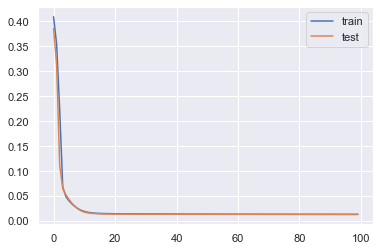

In [102]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [103]:
val_loss = history.history['val_loss']
val_loss_df = pd.DataFrame(val_loss)

print("Model Result (mean and std of error): %.2f (%.2f) MSE" % \
      (val_loss_df.mean(), val_loss_df.std()))



Model Result (mean and std of error): 0.02 (0.05) MSE


In [104]:

# load the saved model
try:
    saved_model.load_weights('../models/best_mlp_model.h5')
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

#saved_model = load_model('../models/best_mlp_model.h5')
# evaluate the model
_, train_acc = saved_model.evaluate(x_train, y_train, verbose=0)
_, test_acc = saved_model.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))


Train: 0.014, Test: 0.014


In [105]:
#regressor.fit(x_train, y_train)
y_hat = saved_model.predict(x_train)
y_hat

array([[0.68281686],
       [0.5064577 ],
       [0.4535513 ],
       ...,
       [0.70452917],
       [0.62264234],
       [0.5624937 ]], dtype=float32)

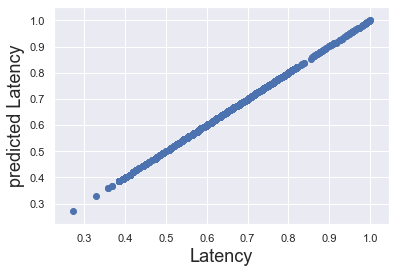

In [106]:
plt.scatter(y_train, y_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
#plt.xlim(-2,3)
#plt.ylim(-3,1)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

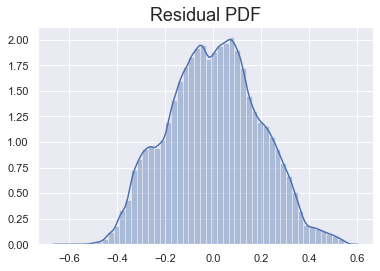

In [107]:
y_train = y_train.values
sns.distplot(y_train - y_hat)
plt.title('Residual PDF', size=18)

In [108]:
# evaluation mean_absolute_percentage_error
train_error =  y_train - y_hat
train_error

mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)

print("Model Result (mean - std of error - min - max): %.2f (%.2f) %.2f %.2f MSE" \
      % (mean_error, std_error, min_error, max_error))

Model Result (mean - std of error - min - max): 0.00 (0.19) -0.63 0.57 MSE


### Testing

In [109]:
y_hat_test = saved_model.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

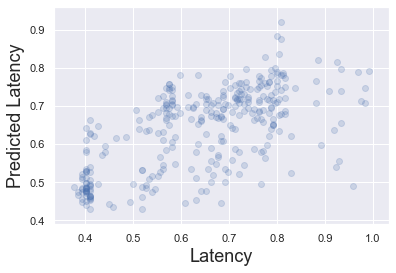

In [110]:
plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

In [111]:
perf = pd.DataFrame(np.exp(y_hat_test), columns=['prediction'])
y_test = y_test.reset_index(drop=True)
perf['target'] = np.exp(y_test)
perf.head()

prediction  target
0       2.022   1.767
1       1.972   1.778
2       1.630   1.682
3       2.057   2.266
4       2.183   1.819

In [112]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

prediction  target  residual  difference%
0         2.022   1.767     0.255       14.424
1         1.972   1.778     0.195       10.943
2         1.630   1.682    -0.052        3.068
3         2.057   2.266    -0.209        9.209
4         2.183   1.819     0.364       19.983
..          ...     ...       ...          ...
312       2.204   2.700    -0.496       18.370
313       1.950   2.134    -0.184        8.625
314       2.166   2.266    -0.100        4.396
315       1.886   2.238    -0.352       15.731
316       2.087   2.219    -0.132        5.945

[317 rows x 4 columns]

In [113]:
perf.describe()

prediction  target  residual  difference%
count     317.000 317.000   317.000      317.000
mean        1.905   1.921    -0.016        9.093
std         0.203   0.292     0.228        6.820
min         1.536   1.457    -0.977        0.072
25%         1.705   1.704    -0.143        3.587
50%         1.952   1.940     0.014        7.775
75%         2.053   2.143     0.137       13.509
max         2.509   2.700     0.430       37.452

In [114]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

prediction  target  residual  difference%
218        1.96    1.96     -0.00         0.07
145        2.08    2.08      0.00         0.08
112        2.11    2.11      0.00         0.08
152        2.04    2.05     -0.00         0.21
96         2.05    2.05      0.01         0.28
88         2.15    2.14      0.01         0.33
146        2.23    2.22      0.01         0.34
220        1.64    1.65     -0.01         0.35
308        2.05    2.06     -0.01         0.39
113        2.08    2.07      0.01         0.44
87         2.00    1.99      0.01         0.44
202        2.00    1.99      0.01         0.47
74         2.02    2.01      0.01         0.59
144        2.21    2.20      0.01         0.63
45         1.56    1.57     -0.01         0.67
77         1.76    1.75      0.01         0.74
103        2.17    2.15      0.02         0.76
94         1.95    1.97     -0.02         0.87
262        2.05    2.07     -0.02         0.90
276        1.98    1.96      0.02         0.91
295        1.96    1.98     -0.02         1.00
249        2.06    2.04      0.02         1.00
171        2.06    2.04      0.02         1.09
307        1.96    1.98     -0.02         1.09
117        1.70    1.68      0.02         1.12
158        2.18    2.20     -0.02         1.13
138        2.01    2.04     -0.02         1.17
238        1.81    1.79      0.02         1.17
279        2.13    2.15     -0.03         1.21
132        1.96    1.94      0.02         1.22
235        1.70    1.68      0.02         1.29
242        2.12    2.14     -0.03         1.29
166        2.03    2.06     -0.03         1.30
287        2.20    2.23     -0.03         1.30
201        2.03    2.00      0.03         1.31
260        2.14    2.17     -0.03         1.41
182        2.10    2.13     -0.03         1.45
141        2.12    2.09      0.03         1.55
161        1.80    1.77      0.03         1.58
187        2.18    2.14      0.03         1.63
28         1.92    1.89      0.03         1.64
176        2.06    2.10     -0.04         1.76
47         2.08    2.05      0.04         1.76
143        2.09    2.06      0.04         1.77
233        2.19    2.23     -0.04         1.81
8          1.54    1.51      0.03         1.86
115        1.72    1.76     -0.03         1.88
253        1.94    1.90      0.04         1.92
116        2.11    2.07      0.04         1.98
150        2.15    2.19     -0.05         2.06
196        2.05    2.10     -0.04         2.12
73         1.94    1.90      0.04         2.16
289        2.14    2.19     -0.05         2.21
128        1.98    1.94      0.04         2.26
186        1.54    1.58     -0.04         2.30
162        1.94    1.99     -0.05         2.30
292        1.83    1.79      0.04         2.32
184        1.67    1.71     -0.04         2.33
270        1.98    2.03     -0.05         2.36
142        1.66    1.70     -0.04         2.50
118        1.87    1.92     -0.05         2.56
304        2.02    2.08     -0.05         2.58
212        2.02    1.97      0.05         2.59
190        2.20    2.26     -0.06         2.64
130        2.12    2.18     -0.06         2.70
278        2.14    2.09      0.06         2.81
241        1.95    1.90      0.05         2.86
291        2.18    2.25     -0.06         2.88
53         1.71    1.76     -0.05         2.88
40         1.69    1.75     -0.05         2.99
286        2.03    2.10     -0.06         2.99
2          1.63    1.68     -0.05         3.07
303        2.18    2.26     -0.07         3.21
154        2.31    2.24      0.07         3.22
192        1.86    1.80      0.06         3.33
252        1.64    1.69     -0.06         3.40
199        1.68    1.74     -0.06         3.44
170        1.82    1.89     -0.07         3.47
231        2.15    2.23     -0.08         3.51
109        2.14    2.07      0.07         3.59
126        2.06    1.99      0.07         3.62
239        1.99    1.92      0.07         3.63
105        2.04    1.97      0.07         3.77
248        1.73    1.80     -0.07         3.79
282       

# Prediction Accuracy

In [115]:
# validation mean_absolute_percentage_error (MAPE)
test_error = np.absolute(perf['residual'] / perf['target'])
mean_error = np.mean(test_error)
min_error = np.min(test_error)
max_error = np.max(test_error)
std_error = np.std(test_error)

print("Mean Absolute Percentate Error std of error (MAPE): [mean: %.2f std: %.2f max: %.2f min: %.2f]" \
      % (mean_error, std_error, max_error, min_error))


Mean Absolute Percentate Error std of error (MAPE): [mean: 0.09 std: 0.07 max: 0.37 min: 0.00]


In [116]:
# validation mean_squared_error  (MSE)
test_error =  np.power(perf['residual'] , 2)
mean_error = np.mean(test_error)
min_error = np.min(test_error)
max_error = np.max(test_error)
std_error = np.std(test_error)

print("Mean Squared Error (MSE): [mean: %.2f std: %.2f max: %.2f min: %.2f]" \
      % (mean_error, std_error, max_error, min_error))


Mean Squared Error (MSE): [mean: 0.05 std: 0.10 max: 0.95 min: 0.00]


R2 is a statistic that will give some information about the goodness of fit of a model. In regression, the R2 coefficient of determination is a statistical measure of how well the regression predictions approximate the real data points. An R2 of 1 indicates that the regression predictions perfectly fit the data.

In [117]:
# R-Squared 
# = 1 -  ( sum of squared residual  / sum of squared variance )
# sum of variance squared = sum (( y - y-mean ) ** 2)
# sum of residual squared = sum (( y-hat - y-mean ) ** 2)
# where y is the observed target, y-mean is the mean of observed target, y-hat is a predicted value

y_mean = np.mean(targets)
sum_squared_residual = np.sum(np.power(perf['residual'] , 2))
sum_squared_variance = np.sum(np.power(targets - y_mean , 2))

R_squared = 1 - ( sum_squared_residual / sum_squared_variance )

R_squared


0.7121296070807219